Numerical to Categorical Conversion:
1. Discretization/Binning (Unsupervised,Supervised,Custom)
2. Binarization

1. Unsupervised ->  (Equal width(uniform),Equal freq(quantile),K means)
2. Supervised -> (Decision Tree)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer

C:\Users\rohit\AppData\Local\Temp\ipykernel_1844\3711735447.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
dataframe = pd.read_csv('train.csv',usecols=['Age','Fare','Survived'])
dataframe

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500
...,...,...,...
886,0,27.0,13.0000
887,1,19.0,30.0000
888,0,NaN,23.4500
889,1,26.0,30.0000


In [7]:
dataframe.dropna(inplace=True)
dataframe.shape

(714, 3)

In [9]:
dataframe.sample(5)

,Survived,Age,Fare
291,1,19.0,91.0792
127,1,24.0,7.1417
777,1,5.0,12.4750
862,1,48.0,25.9292
704,0,26.0,7.8542


In [10]:
X = dataframe.iloc[:,1:]
Y = dataframe.iloc[:,0]

In [11]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [12]:
clf = DecisionTreeClassifier()
clf.fit(X_train,Y_train)
y_pred = clf.predict(X_test)
accuracy_score(Y_test,y_pred)

0.6153846153846154

In [13]:
np.mean(cross_val_score(DecisionTreeClassifier(),X,Y,cv=10,scoring='accuracy'))

0.6331181533646322

In [14]:
kbin_age = KBinsDiscretizer(n_bins=10,encode='ordinal',strategy='quantile')
kbin_fare = KBinsDiscretizer(n_bins=10,encode='ordinal',strategy='quantile')

In [15]:
trf = ColumnTransformer([
    ('first',kbin_age,[0]),
    ('second',kbin_fare,[1])
])

In [16]:
X_train_trf = trf.fit_transform(X_train)
X_test_trf = trf.fit_transform(X_test)

In [19]:
trf.named_transformers_['first'].n_bins_,trf.named_transformers_['first'].bin_edges_

(array([10]),
 array([array([ 1. , 11. , 17. , 20.6, 24. , 28. , 30.1, 34.4, 38.6, 47.8, 62. ])],
       dtype=object))

In [20]:
trf.named_transformers_['second'].n_bins_,trf.named_transformers_['second'].bin_edges_

(array([10]),
 array([array([  0.     ,   7.74336,   7.925  ,   8.6625 ,  10.5    ,  14.4542 ,
                22.62   ,  28.39   ,  38.1    ,  57.78336, 512.3292 ])          ],
       dtype=object))

In [21]:
output = pd.DataFrame({
    'age':X_train['Age'],
    'age_trf':X_train_trf[:,0],
    'fare':X_train['Fare'],
    'fare_trf':X_train_trf[:,1]
})
output['age_labels'] = pd.cut(x=X_train['Age'],bins=trf.named_transformers_['first'].bin_edges_[0].tolist())
output['fare_labels'] = pd.cut(x=X_train['Fare'],bins=trf.named_transformers_['second'].bin_edges_[0].tolist())
output.sample(5)

,age,age_trf,fare,fare_trf,age_labels,fare_labels
493,71.0,9.0,49.5042,7.0,NaN,"(38.1, 57.783]"
540,36.0,7.0,71.0000,8.0,"(34.4, 38.6]","(57.783, 512.329]"
841,16.0,1.0,10.5000,3.0,"(11.0, 17.0]","(8.662, 10.5]"
156,16.0,1.0,7.7333,0.0,"(11.0, 17.0]","(0.0, 7.743]"
696,44.0,8.0,8.0500,2.0,"(38.6, 47.8]","(7.925, 8.662]"


In [22]:
clf.fit(X_train_trf,Y_train)
y_pred_trf = clf.predict(X_test_trf)
accuracy_score(Y_test,y_pred_trf)

0.6853146853146853

In [23]:
X_trf = trf.fit_transform(X)
np.mean(cross_val_score(DecisionTreeClassifier(),X_trf,Y,cv=10,scoring='accuracy'))

0.682140062597809

In [27]:
def discretize(bins,strategy):
    kbin_age = KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy=strategy)
    kbin_fare = KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy=strategy)
    
    trf = ColumnTransformer([
        ('first',kbin_age,[0]),
        ('second',kbin_fare,[1])
    ])
    
    X_trf = trf.fit_transform(X)
    print(np.mean(cross_val_score(DecisionTreeClassifier(),X,Y,cv=10,scoring='accuracy')))
    
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.hist(X['Age'])
    plt.title("Before")

    plt.subplot(122)
    plt.hist(X_trf[:,0],color='red')
    plt.title("After")

    plt.show()
    
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.hist(X['Fare'])
    plt.title("Before")

    plt.subplot(122)
    plt.hist(X_trf[:,1],color='red')
    plt.title("Fare")

    plt.show()

0.6288928012519561


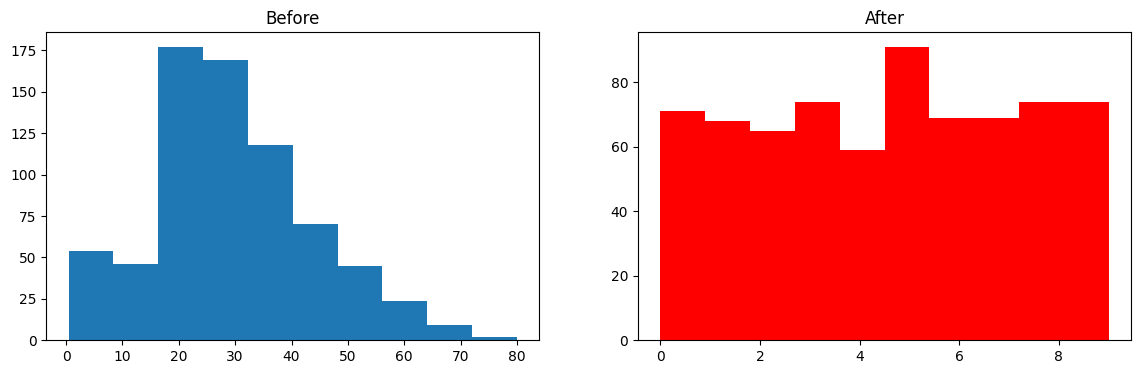

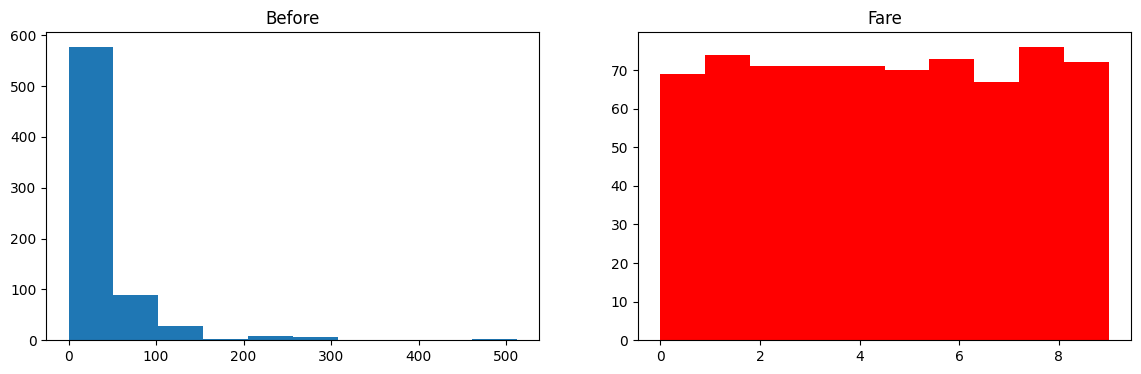

In [28]:
discretize(10,'quantile')

C:\Users\rohit\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
C:\Users\rohit\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


0.6233176838810641


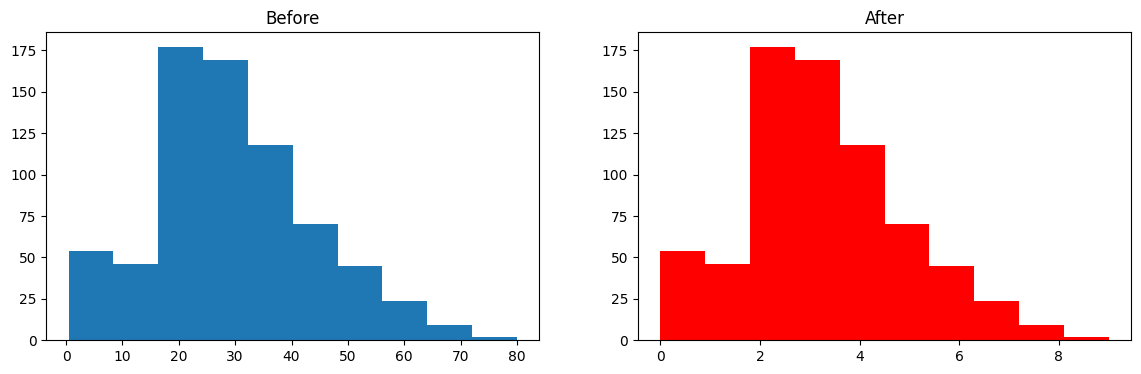

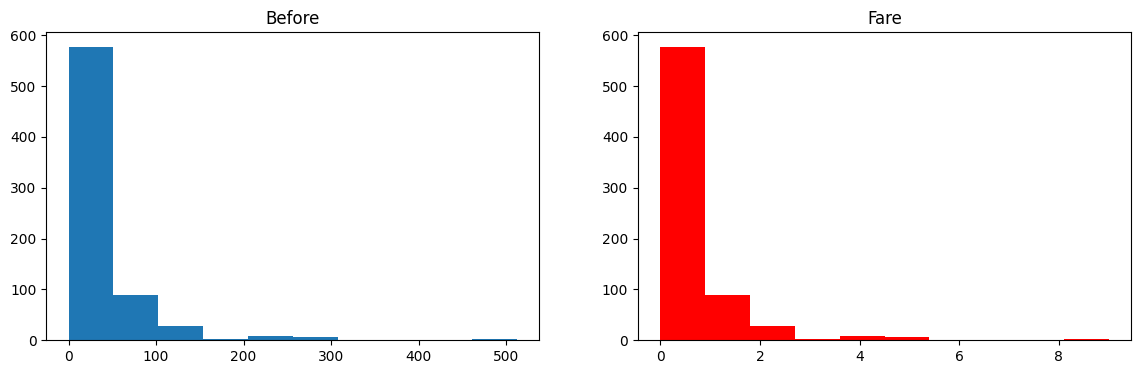

In [29]:
discretize(10,'uniform')

C:\Users\rohit\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
C:\Users\rohit\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


0.6303208137715179


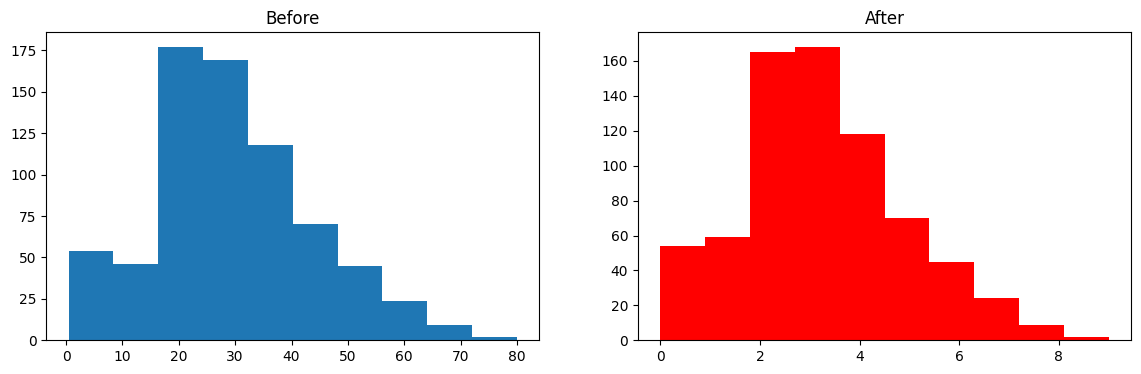

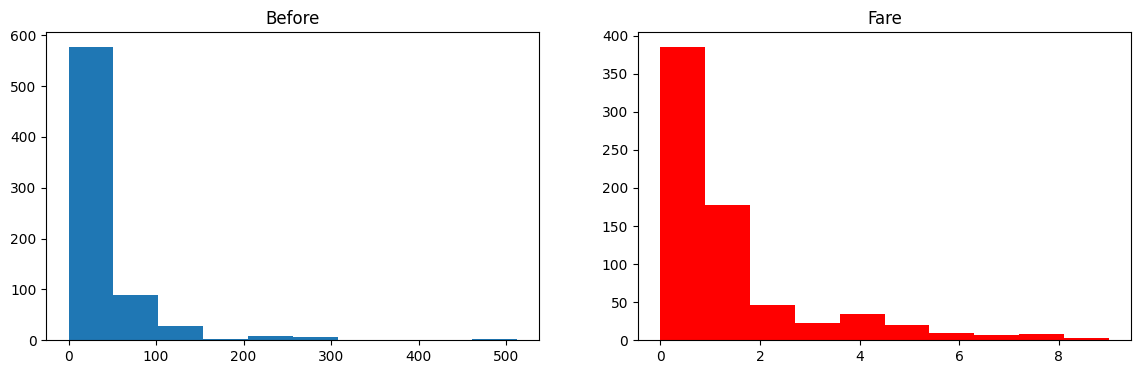

In [30]:
discretize(10,'kmeans')